In [1]:
!pip install pyxdf
!pip install mne
!pip install pandas
!pip install --upgrade jupyterlab ipympl ipywidgets


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
print(sys.version)

3.11.1 (v3.11.1:a7a450f84a, Dec  6 2022, 15:24:06) [Clang 13.0.0 (clang-1300.0.29.30)]


In [3]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mne
import pandas as pd
import os

In [4]:
aep_data_luka_path = '2_vep_2025-08-05_06-51-40_1.xdf'
aep_data_luka = pyxdf.load_xdf(aep_data_luka_path)

In [5]:
xdf_data = aep_data_luka[0]

In [6]:
class ExperimentData:
    def _read_metadata(self, original_filename):
        # Read info of the first stream
        info = self._xdf_data[0]['info']
        self.metadata = {
            "effective_sample_rate": info['effective_srate'],
            "subject": {
                # "name": info['desc'][0]['subject'][0]['name'][0],
                # "alertness": info['desc'][0]['subject'][0]['alertness'][0],
                "id": info['desc'][0]['subject'][0]['id'][0],
                "group": info['desc'][0]['subject'][0]['group'][0],
                "session": info['desc'][0]['subject'][0]['session'][0]
            },
            "markers": list(set(self.marker_data)),
            # "experiment_variant": info['desc'][0]['experiment'][0]['variant'][0],
            "original_filename": original_filename
        }
    
    def _read_eeg_data(self):
        # Read data of the first stream
        self.eeg_time = self._xdf_data[0]['time_stamps']
        self._time_offset = min(self.eeg_time)
        self.eeg_time = self.eeg_time - self._time_offset
        self.eeg_data = self._xdf_data[0]['time_series'][:, :8]
        # self.accelerometer_data = self._xdf_data[0]['time_series'][:, 8:11]
        # self.gyroscope_data = self._xdf_data[0]['time_series'][:, 11:14]
        # self.battery_level_data = self._xdf_data[0]['time_series'][:, 14]
        # self.counter_data = self._xdf_data[0]['time_series'][:, 15]
        # self.validation_indicator_data = self._xdf_data[0]['time_series'][:, 16]
        
    def _read_marker_data(self):
        # Read data of the second stream
        self.marker_time = self._xdf_data[1]['time_stamps']
        self.marker_time = self.marker_time - self._time_offset
        self.marker_data = [x[0] for x in self._xdf_data[1]['time_series']]
        
    def __init__(self, xdf_path):
        self._xdf_data = pyxdf.load_xdf(xdf_path)[0]
        self._read_eeg_data()
        self._read_marker_data()
        self._read_metadata(os.path.basename(xdf_path))

In [7]:
# data_1 = ExperimentData('1_vep_2025-08-02_11-30-26_1.xdf')
# data_2 = ExperimentData('1/7/1_aep_600_(with_feedback)_2024-02-01_17-36-47_7.xdf')
# data_3 = ExperimentData('2/1/2_aep_2024-02-01_15-51-19_1.xdf')
# print(data_1.marker_time)
# print(data_2.metadata)
# print(data_3.metadata)

In [8]:
# data_1.eeg_data

In [9]:
# data_1.eeg_time

In [10]:
class ExperimentDataAEP(ExperimentData):
    def __init__(self, xdf_path, min_frequency=0.5, max_frequency=30, bad_ch=None):
        super().__init__(xdf_path)
        self._filter_data(min_frequency, max_frequency)
        self._create_montage()
        self._filter_markers()
        self._read_trials()
        if bad_ch is not None:
            self._raw.info["bads"].append(bad_ch)
            self._filter_markers()

        
    def _filter_markers(self):
        # Remove markers that aren't in our interest
        events = []
        for i, marker in enumerate(self.marker_data):
            if marker in ['oddball', 'standard'] and self.marker_data[i + 1] == 'trial-end':
                eeg_start_index = np.argmax(self.eeg_time >= self.marker_time[i]) - 1  # Max timestamp that is less than current marker time (trial-begin)
                events.append([eeg_start_index, 0, 1 if marker == 'standard' else 2])
        events = np.array(events)
        print(events.shape)
        event_dict = dict(standard=1, oddball=2)
        self._epochs = mne.Epochs(self._raw, events, event_id=event_dict, tmin=-0.5, tmax=1.5, preload=True)

    def _create_montage(self):
        montage = mne.channels.make_standard_montage("standard_1020")
        self._raw.set_montage(montage)

    def _filter_data(self, min_frequency, max_frequency):
        mne.set_log_level('WARNING')
        info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8, sfreq=250)
        raw = mne.io.RawArray([1e-6 * self.eeg_data[:, i] for i in range(8)], info)
        raw.notch_filter(freqs=[50])
        raw.filter(min_frequency, max_frequency)
        self._raw = raw
        self.eeg_data = np.transpose(raw.get_data())

    def _read_trials(self):
        self.trials = []
        # The 'trial-begin' and 'trial-end' are the usual markers to look for.
        # However, if 'trial-begin' is followed by 'response-received-enter' before getting to 'trial-end', it isn't a real trial and must be skipped.
        for i, marker in enumerate(self.marker_data):
            if marker == 'trial-begin':
                if self.marker_data[i + 1] in ['oddball', 'standard'] and self.marker_data[i + 2] == 'trial-end':
                    eeg_start_index = np.argmax(self.eeg_time >= self.marker_time[i]) - 1  # Max timestamp that is less than current marker time (trial-begin)
                    eeg_end_index = np.argmax(self.eeg_time >= self.marker_time[i + 2])
                    marker_time = self.marker_time[i:i+3]
                    marker_data = self.marker_data[i:i+3]
                    self.trials.append((self.eeg_time[eeg_start_index:eeg_end_index], self.eeg_data[eeg_start_index:eeg_end_index, :], marker_time, marker_data))
                else:
                    print(f'Incorrect trial, two following events are {self.marker_data[i + 1]} and {self.marker_data[i + 2]}')
                    pass

    def _plot_markers(self, ax, x_values, y_coord, labels):
        for x, label in zip(x_values, labels):
            ax.vlines(x, ymin=-y_coord, ymax=y_coord, colors='r', linestyles='dashed')
            ax.text(x, y_coord, label, rotation=90, verticalalignment='bottom', horizontalalignment='right')
        
    def plot_all_channels(self):
        fig = data_aep_1._raw.plot(duration=30, scalings='auto')

    def plot_channel(self, channel_index=0, show_markers=False):
        fig, ax = plt.subplots()
        ax.plot(self.eeg_time, self.eeg_data[:, channel_index])
        if show_markers:
            # Create vertical lines
            label_y_coord = np.max(np.abs(self.eeg_data[:, channel_index]))
            self._plot_markers(ax, self.marker_time, label_y_coord, self.marker_data) 

    def plot_fft(self, channel_index=0):
        fig, ax = plt.subplots()
        signal_fft = np.fft.rfft(self.eeg_data[:, channel_index])
        signal_spectrum = abs(signal_fft)
        freq = np.fft.rfftfreq(len(self.eeg_data[:, channel_index]), 1./250)  # 250 is the sampling rate
        ax.plot(freq, signal_spectrum)
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel('Amplitude')

    def plot_trial(self, trial_index, show_markers=True):
        # Plots a trial from 'trial-begin' to 'trial-end' event
        eeg_time, eeg_data, marker_time, marker_data = self.trials[trial_index]
        fig, ax = plt.subplots()
        ax.plot(eeg_time - min(eeg_time), eeg_data)
        if show_markers:
            # Create vertical lines
            label_y_coord = np.max(np.abs(eeg_data))
            self._plot_markers(ax, marker_time - min(eeg_time), label_y_coord, marker_data)

    def plot_sensors(self):
        self._raw.plot_sensors(show_names=True)

    def plot_epochs(self):
        fig = self._epochs.plot(scalings='auto', events=True)

    def plot_epoch(self, epoch_index):
        # Plots a single epoch, starting from -0.2 sec before stimulus, and ending 0.2s before the next stimulus
        epoch = data_aep_1._epochs[epoch_index].plot(events=True, scalings='auto')
        data_aep_1._epochs[epoch_index]
        
    def plot_compare_conditions(self, confidence_interval=0.95):
        evokeds = dict(
            standard=list(self._epochs["standard"].iter_evoked()),
            oddball=list(self._epochs["oddball"].iter_evoked()),
        )
        mne.viz.plot_compare_evokeds(evokeds, combine="mean", ci=confidence_interval)

# data_aep_1.metadata

In [11]:
data_aep_1 = ExperimentDataAEP('2_vep_2025-08-05_06-51-40_1.xdf', min_frequency=1, max_frequency=30, bad_ch=None)
data_aep_2 = ExperimentDataAEP('2_vep_2025-08-05_06-51-40_1.xdf', min_frequency=1, max_frequency=15, bad_ch=None)
data_aep_3 = ExperimentDataAEP('2_vep_2025-08-05_06-51-40_1.xdf', min_frequency=1, max_frequency=10, bad_ch=None)
data_aep_4 = ExperimentDataAEP('2_vep_2025-08-05_06-51-40_1.xdf', min_frequency=.5, max_frequency=10, bad_ch=None)
data_aep_wiko = ExperimentDataAEP('3_vep_2025-08-06_07-59-51_1.xdf', min_frequency=1, max_frequency=15, bad_ch='Pz')
data_aep_nani = ExperimentDataAEP('4_vep_2025-08-12_06-41-43_1.xdf', min_frequency=1, max_frequency=15, bad_ch=None)

(391, 3)
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are oddball and response-received-enter
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are standard and response-received-enter
(391, 3)
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are standard and response-received-enter
Incorrect trial, two following events are oddball and response-received-enter
Incorrect trial, two following event

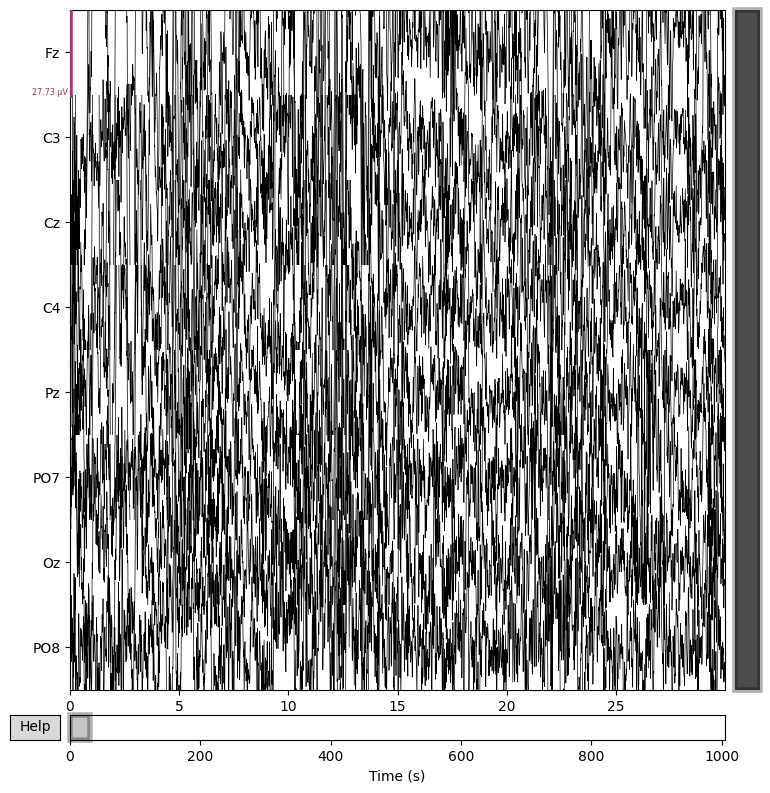

In [12]:
data_aep_2.plot_all_channels()

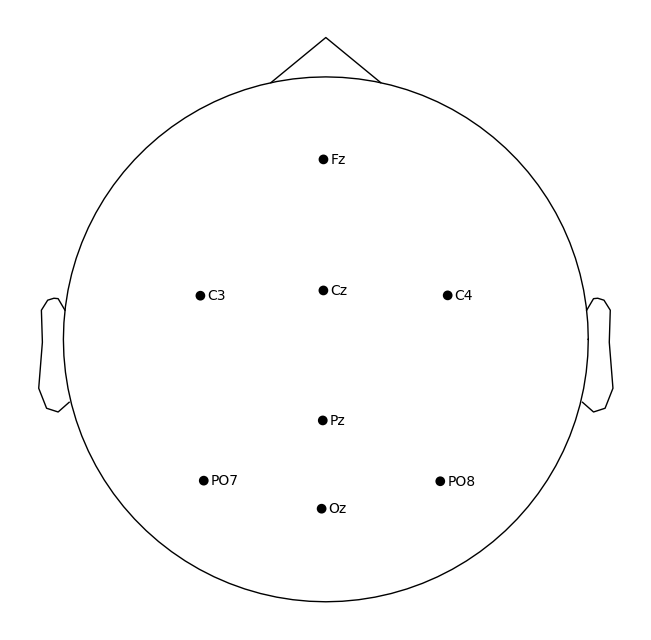

In [13]:
data_aep_2.plot_sensors()

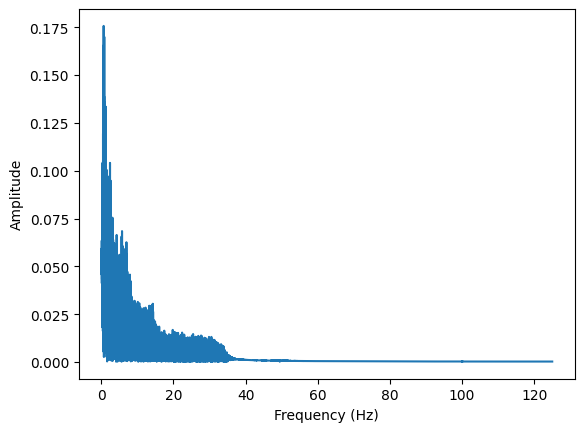

In [14]:
# %matplotlib widget
data_aep_1.plot_fft(0)
plt.show()

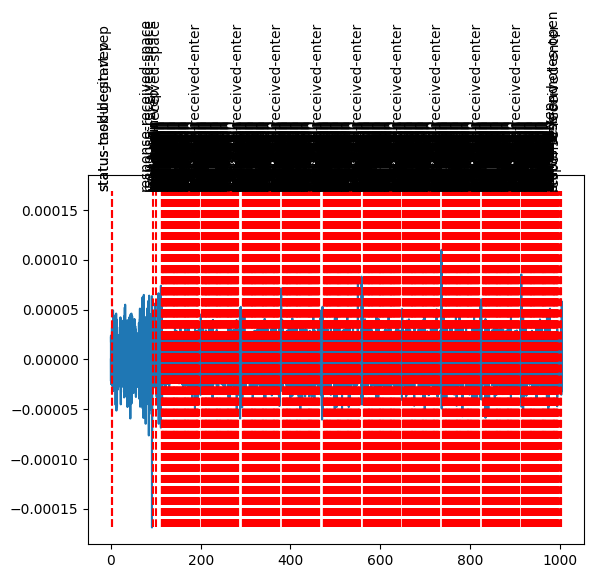

In [15]:
# %matplotlib widget
data_aep_1.plot_channel(7, show_markers=True)
plt.show()

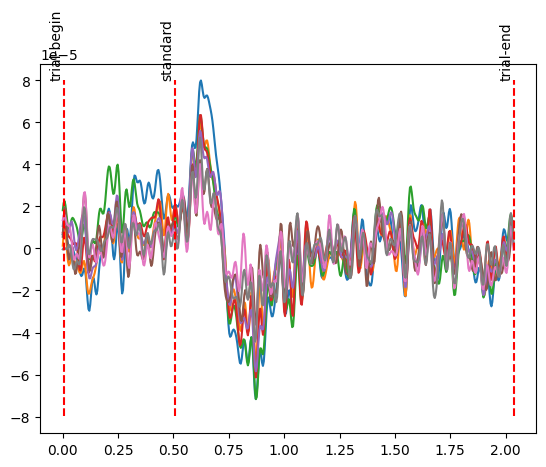

In [16]:
data_aep_1.plot_trial(0, show_markers=True)
plt.show()

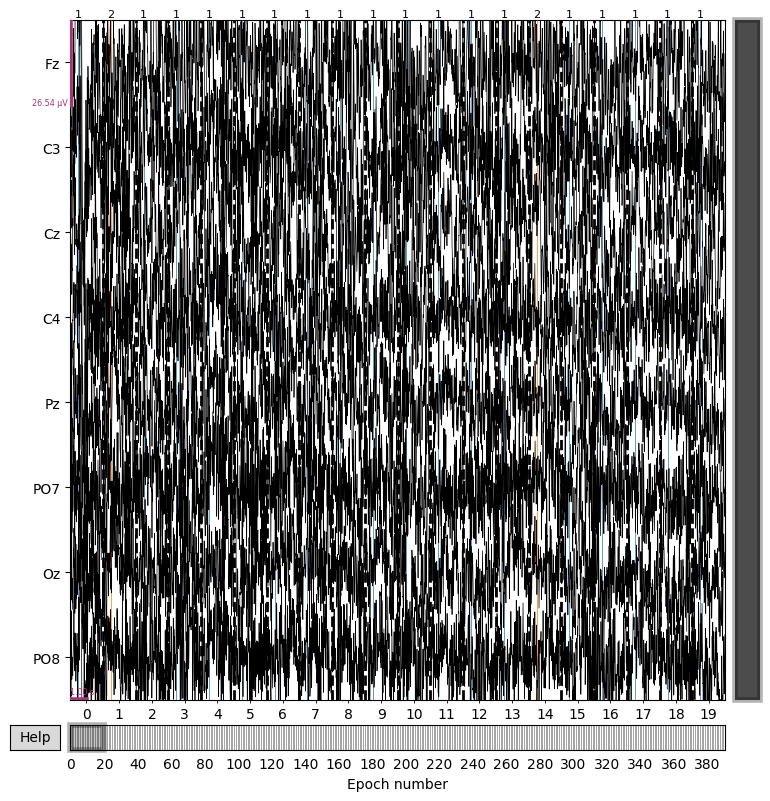

In [17]:
data_aep_1.plot_epochs()

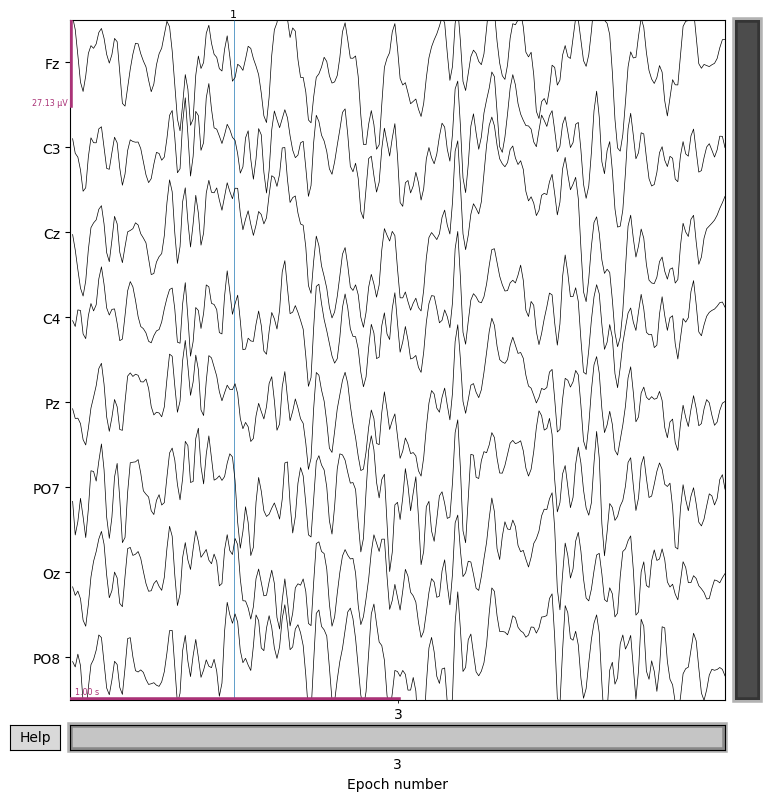

In [18]:
data_aep_1.plot_epoch(3)

In [19]:
# See the possible results of rejecting certain epochs
# reject_criteria = dict(eeg=200e-6)  # 300 µV
# copy = data_aep_1._epochs.copy()
# copy.drop_bad(reject=reject_criteria)
# fig = copy.plot_drop_log()

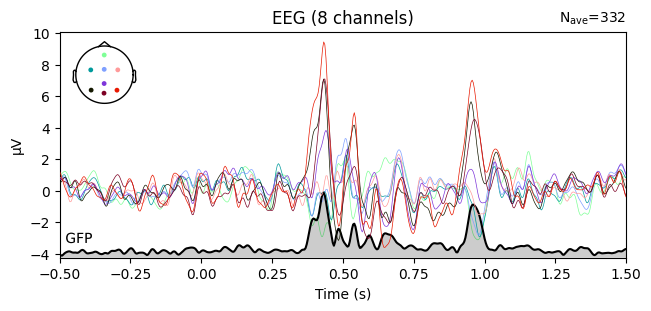

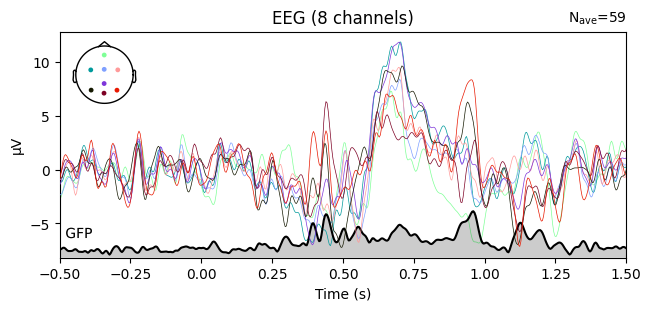

In [20]:
standard = data_aep_1._epochs["standard"].average()
oddball = data_aep_1._epochs["oddball"].average()
fig = standard.plot(gfp=True, spatial_colors=True)
fig = oddball.plot(gfp=True, spatial_colors=True)

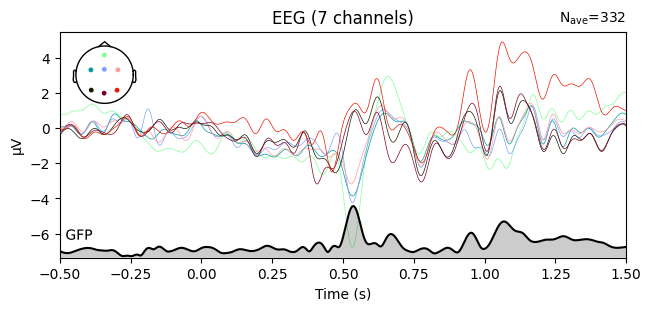

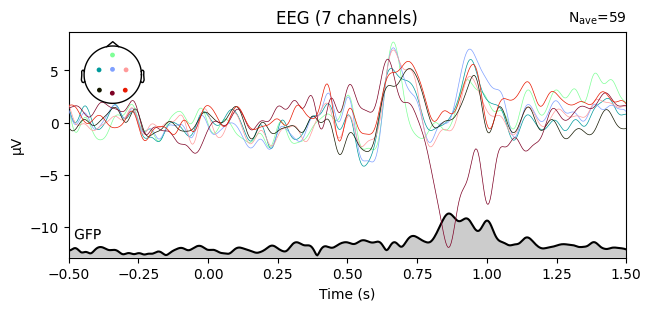

In [21]:
standard = data_aep_wiko._epochs["standard"].average()
oddball = data_aep_wiko._epochs["oddball"].average()
fig = standard.plot(gfp=True, spatial_colors=True)
fig = oddball.plot(gfp=True, spatial_colors=True)

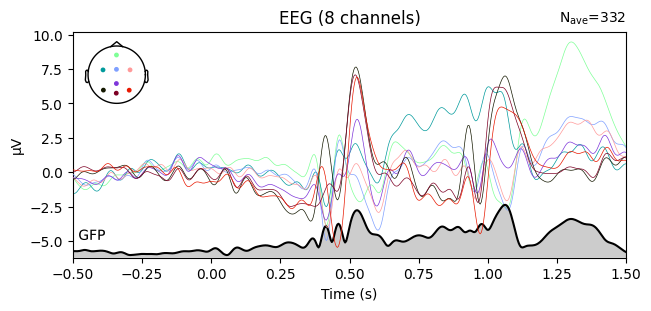

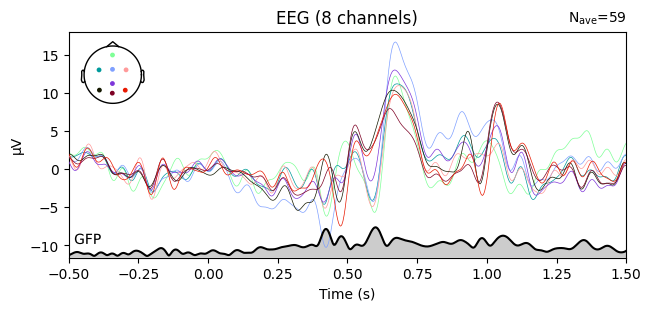

In [22]:
standard = data_aep_nani._epochs["standard"].average()
oddball = data_aep_nani._epochs["oddball"].average()
fig = standard.plot(gfp=True, spatial_colors=True)
fig = oddball.plot(gfp=True, spatial_colors=True)

In [23]:
# Reject some epochs and plot
# reject_criteria = dict(eeg=200e-6)  # 300 µV
# data_aep_1._epochs.drop_bad(reject=reject_criteria)
# fig = data_aep_1._epochs.plot_drop_log()

The auditory N1 component is reliably produced by the onset of auditory stimuli; it peaks around 100 ms; it is largest over the midline of the head, anterior to the vertex; and it has negative polarity (i.e., a negative microvolt value). In contrast, the P3 component is elicited by infrequent but task-relevant stimuli; peaks around 300 ms; is largest over the midline posterior region of the scalp, and has positive polarity.

The N1 component elicited by auditory stimuli, mentioned above, can be used in a variety of ways. For one, its amplitude is modulated by attention; attended sounds elicit a larger N1 than unattended sounds. This allows researchers to use the component to investigate many different manipulations of auditory attention. For example, research has shown that auditory attention can be spatially directed, by requiring participants to attend to different spatial locations and playing sounds both from those, and from unattended locations. These studies showed larger N1s in response to stimuli from attended than unattended locations. Moreover, the fact that these effects occurred on the N1, which occurs approximately 100 ms after stimulus onset, allowed insights into the time course of spatially selective attention. Indeed, a common use of ERPs is to identify the earliest point in time at which the brain appears to distinguish between different types of stimuli (or the same stimuli under different contexts).

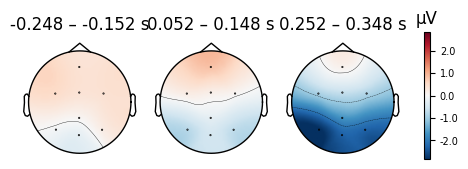

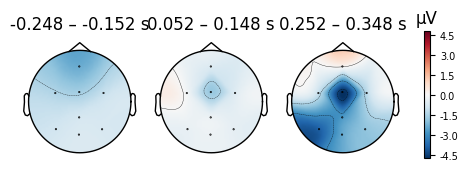

In [24]:
fig = standard.plot_topomap(times=[-0.2, 0.1, 0.3], average=0.1)
fig = oddball.plot_topomap(times=[-0.2, 0.1, 0.3], average=0.1)

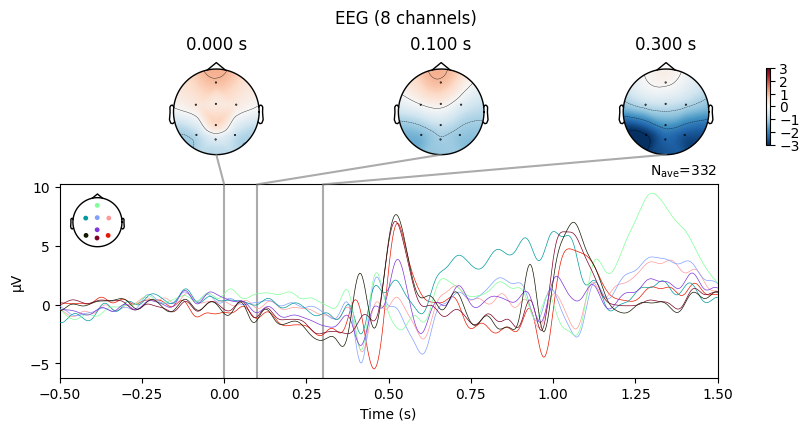

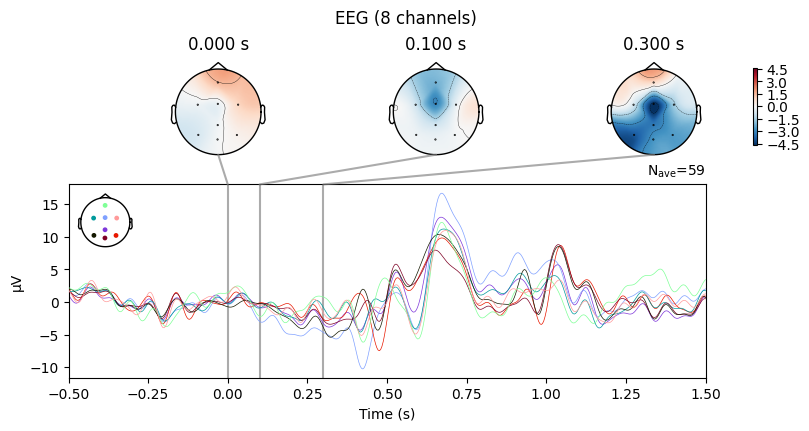

In [25]:
fig = standard.plot_joint(times=[0, 0.1, 0.3])
fig = oddball.plot_joint(times=[0, 0.1, 0.3])

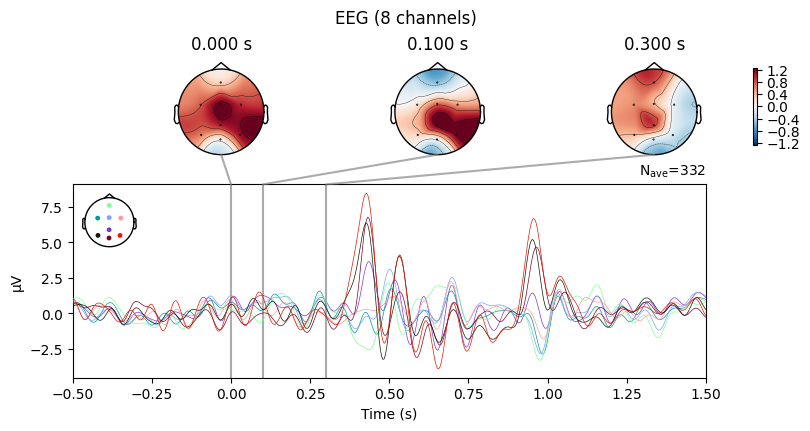

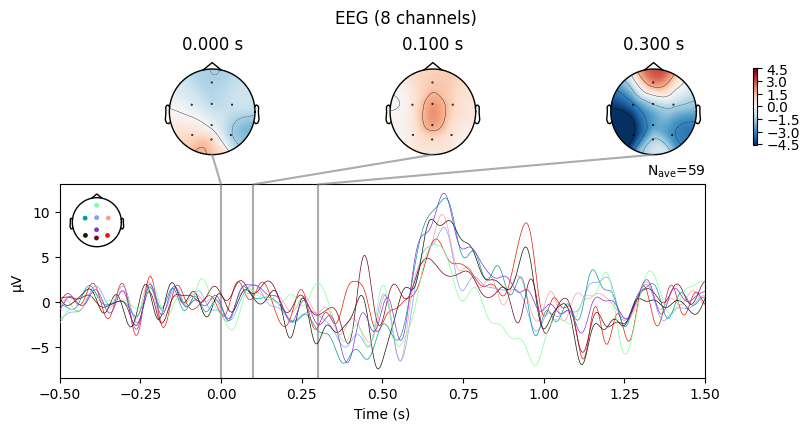

In [26]:
# Reject some epochs and plot
# reject_criteria = dict(eeg=300e-6)  # 300 µV
# data_aep_2._epochs.drop_bad(reject=reject_criteria)
# fig = data_aep_2._epochs.plot_drop_log()

standard = data_aep_2._epochs["standard"].average()
oddball = data_aep_2._epochs["oddball"].average()
fig = standard.plot_joint(times=[-0, 0.1, 0.3])
fig = oddball.plot_joint(times=[-0, 0.1, 0.3])

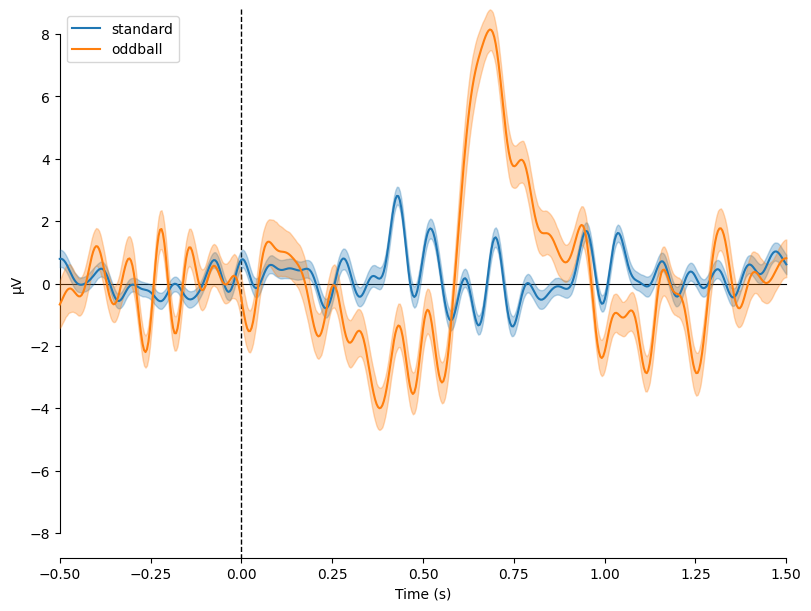

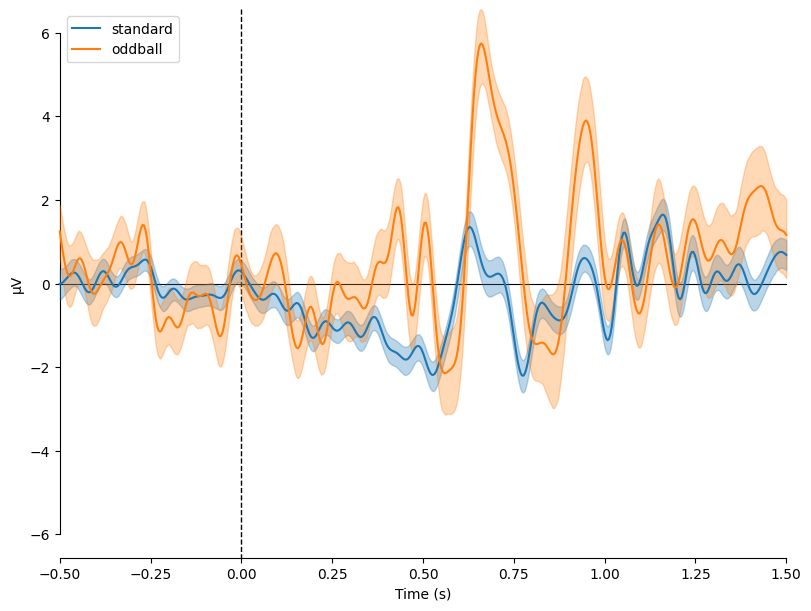

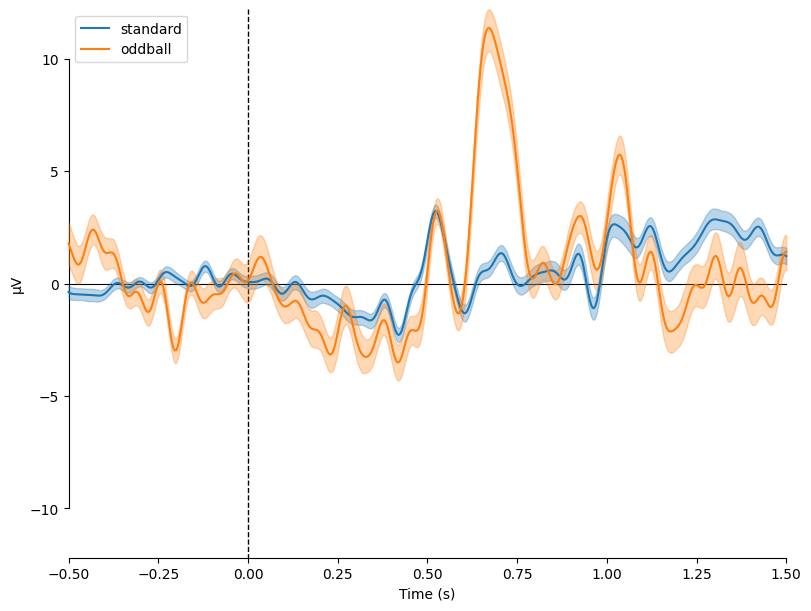

In [34]:
# data_aep_1.plot_compare_conditions(confidence_interval=0.95)
data_aep_2.plot_compare_conditions(confidence_interval=0.5)
# data_aep_3.plot_compare_conditions(confidence_interval=0.95)
# data_aep_4.plot_compare_conditions(confidence_interval=0.95)
data_aep_wiko.plot_compare_conditions(confidence_interval=0.5)
data_aep_nani.plot_compare_conditions(confidence_interval=0.5)

In [28]:
# print([x for x in data_2.metadata['markers'] if 'rt' not in x])

In [29]:
# data_aep_feedback.plot_trial(10)

In [30]:
# data_aep_feedback.plot_compare_conditions()

In [31]:
# standard = data_aep_feedback._epochs["standard"].average()
# oddball = data_aep_feedback._epochs["oddball"].average()
# fig = standard.plot_joint(times=[0, 0.32, 0.5])
# fig = oddball.plot_joint(times=[0, 0.41, 0.55])

In [32]:
# x = [x for x in data_aep_feedback._response_time if x is not None]
# plt.figure()
# hist, bins = np.histogram(x, bins=30, range=[200, 800])
# plt.hist(bins[:-1], bins, weights=hist)
# plt.show()

In [33]:
# np.mean(x), np.std(x)